# the $k$-nearest neighbors (kNN) supervised learning algorithm

* can be used for regression or classification
* non-parametric
* imposes only mild structural assumptions about the data

let's explore $k$-nearest neighbor classification.

training data examples: $\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), ..., (\mathbf{x}_n, y_n)\}$ where $\mathbf{x}_i$ is the feature vector and $y_i \in \{0, 1\}$ is the label on data point $i$. This is a binary classification since each data point is labeled with $0$ or $1$.

the $k$-NN algorithm uses the training data to classify new data points. say we have a new data point $\mathbf{x}$ but we don't know its label. the $k$-NN algorithm predicts the class of this data point as:
\begin{equation}
    \hat{y}(\mathbf{x})= \frac{1}{k} \displaystyle \sum_{\mathbf{x}_i \in N_k(\mathbf{x})} y_i
\end{equation}
where $N_k(x)$ is the *neighborhood* of $\mathbf{x}$ defined as the $k$ "closest" points in the training data set. For "closest" to be mathematically defined, we need a distance metric. One such distance metric is Euclidean distance. In words, the $k$ data points closest to $\mathbf{x}$ vote on whether we should classify this point as a 0 or 1 with their labels.

In [6]:
using CSV
using DataFrames
using PyPlot
using ScikitLearn # machine learning package
using StatsBase
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

# (optional) change the style. see styles here: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-white")   

## classifying breast tumors as malignant or benign

source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

> Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The mean radius and smoothness of the cell nuclei (the two features) and the outcome (M = malignant, B = benign) of the tumor are in the `breast_cancer_data.csv`.

In [7]:
df = CSV.read("breast_cancer_data.csv")
first(df, 5)

,mean_radius,mean_smoothness,outcome
,Float64,Float64,String
1,13.85,1.495,B
2,9.668,2.275,B
3,9.295,2.388,B
4,19.69,4.585,M
5,9.755,1.243,B


In [8]:
by(df, :outcome, total=:outcome=>length)

,outcome,total
,String,Int64
1,B,180
2,M,120


let's map the outcomes to a number, 0 or 1, to facilitate the NN algo.

benign (B) : 0<br>
malignant (M) : 1

In [9]:
df[!, :class] = map(tumor -> tumor == "M" ? 1 : 0, df[:, :outcome])
first(df,5)

,mean_radius,mean_smoothness,outcome,class
,Float64,Float64,String,Int64
1,13.85,1.495,B,0
2,9.668,2.275,B,0
3,9.295,2.388,B,0
4,19.69,4.585,M,1
5,9.755,1.243,B,0


let's also have a color scheme for the class labels.

In [10]:
color_scheme = Dict("M"=>"r", "B"=>"g")

Dict{String,String} with 2 entries:
  "B" => "g"
  "M" => "r"

since this is a two-dimensional feature space, we have the luxury of visualizing how the classes are distributed in feature space. in practice, we do not have this luxury. I choose a 2D feature space for pedagogical purposes :)

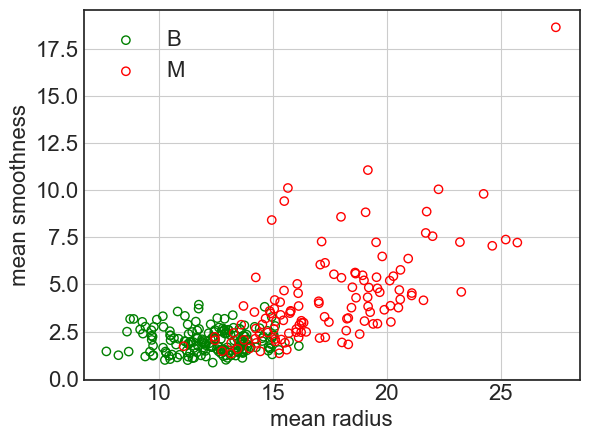

In [11]:
#x_new = [20.0,5.0]
figure()
xlabel("mean radius")
ylabel("mean smoothness")
for df_o in groupby(df, :outcome)
    outcome = df_o[1, :outcome]
    scatter(df_o[:,:mean_radius], df_o[:,:mean_smoothness], facecolor="None",
        edgecolor=color_scheme[outcome],label = outcome)
end
#scatter(x_new[1],x_new[2])
legend()
grid("on")

### using Scikitlearn for $k$-nearest neighbor classification

scikitlearn documentation for `KNeighborsClassifier` [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [12]:
@sk_import neighbors : KNeighborsClassifier
@sk_import model_selection : train_test_split
@sk_import metrics : confusion_matrix

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore /Users/kingsleychukwu/.julia/packages/ScikitLearn/bo2Pt/src/Skcore.jl:140


PyObject <function confusion_matrix at 0x1a40dc9510>

scikitlearn takes as input:
* a feature matrix `X`, which must be `n_samples` by `n_features`
* a target vector `y`, which must be `n_samples` long (of course)

In [13]:
n_tumors = nrow(df)
x = zeros(n_tumors, 2)
y = zeros(n_tumors)
for (i, tumor) in enumerate(eachrow(df))
    x[i,1]=tumor[:mean_radius]
    x[i,2]=tumor[:mean_smoothness]
    y[i]=tumor[:class]
end

y

300-element Array{Float64,1}:
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 0.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0

construct a nearest neighbor object in scikitlearn

In [14]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x,y)

PyObject KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

pass the `KNeighborsClassifier` object our training data. this will be used to make predictions on future, unseen data.

we can now make predictions on new, unseen data. that is, if we know the mean radius and mean smoothness of a new tumor, we can make a prediction about whether this tumor is malignant or benign. let's imagine we take measurements on a new tumor and it has the feature vector `x_new` below. we aim to predict whether it is benign or malignant.

In [15]:
# new tumor. unknown if malignant or benign...
#x_new = [10.0 1.5] # should be B
x_new = [20.0 5.0] # should be M


1×2 Array{Float64,2}:
 20.0  5.0

first, let's plot where it falls in feature space

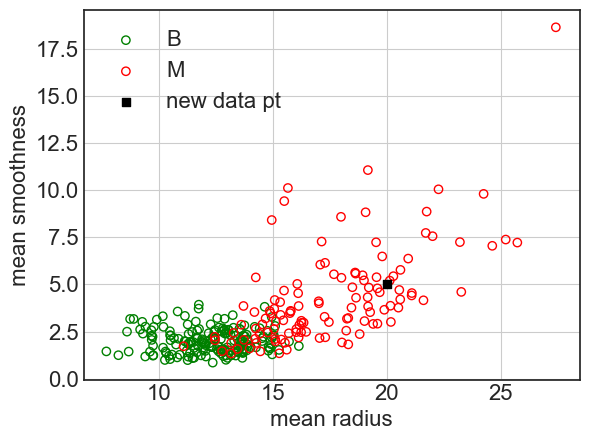

In [16]:
figure()
xlabel("mean radius")
ylabel("mean smoothness")
for df_o in groupby(df, :outcome)
    outcome = df_o[1, :outcome]
    scatter(df_o[:,:mean_radius], df_o[:,:mean_smoothness], facecolor="None",
        edgecolor=color_scheme[outcome],label = outcome)
end
scatter(x_new[1],x_new[2], color="k", marker="s",label="new data pt")
legend()
grid("on")

predict whether this new tumor is benign or malignant

In [17]:
knn.predict(x_new)

1-element Array{Float64,1}:
 1.0

visualize the decision boundary

In [18]:
sum(knn.predict(x).==y)

271

In [22]:
radius = 5:0.1:30
smoothness = 0:0.1:18
knn_prediction = zeros(length(smoothness), length(radius))
fill!(knn_prediction, NaN)

for i = 1:length(radius)
    for j = 1:length(smoothness)
        x_here = [radius[i] smoothness[j]]
        knn.predict(x_here)
        #knn_prediction[j,i] = knn.predict(x_here)[1]
    end
end
knn_prediction

181×251 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  Na

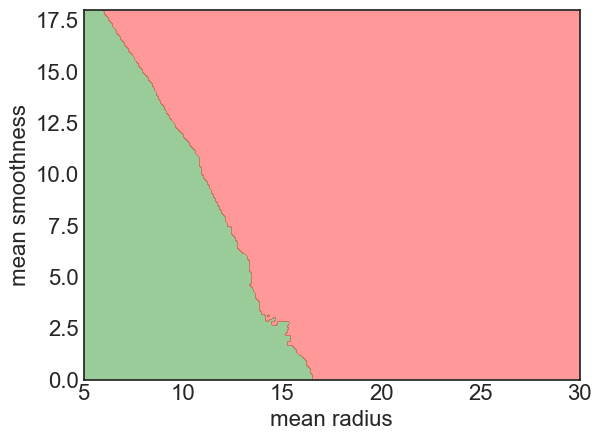

PyObject <matplotlib.contour.QuadContourSet object at 0x1a42e54780>

In [15]:
figure()
xlabel("mean radius")
ylabel("mean smoothness")
contourf(radius,smoothness,knn_prediction,[-1.0,0.5,2.0],colors=["g","r"], alpha = 0.4)
#for df_o in groupby(df, :outcome)
#    outcome = df_o[1, :outcome]
#    scatter(df_o[:,:mean_radius], df_o[:,:mean_smoothness], facecolor="None",
#        edgecolor=color_scheme[outcome],label = outcome)
#end

we can compute the accuracy of the prediction on the training data. but when $k=1$ we get 100% accuracy by construction!

### the test/train paradigm

randomly split your data set into a training and test set. train the $k$-NN algo on the training data, then use the trained model to make predictions on data in the test set. we can compare the predicted label to the true label. the test set error is a quality prediction of generalization error on *unseen* data. we could write our own code for this, but scikitlearn provides `test_train_split` for us.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
println("size of the ")
println("size of the ")
y_train

size of the 
size of the 


180-element Array{Float64,1}:
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0
 ⋮  
 0.0
 1.0
 1.0
 0.0
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 0.0
 0.0

to fully assess the performance of our model, trained on the training set, and tested on the test set, we can plot a so-called confusion matrix. it tells us about false positives, true positives, false negatives, and true negatives.

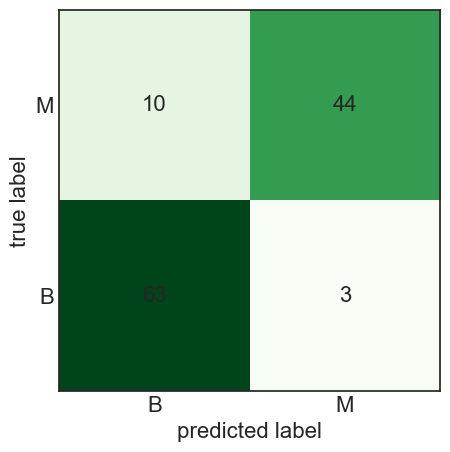

In [17]:
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
function plot_confusion_matrix(y_true::Array{Float64}, y_pred::Array{Float64}, classes::Array{String})
    # calculate confusion matrix from scikitlearn
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Greens)
    ax.set(
        xlim=[-0.5, 1.5],
        ylim=[-0.5, 1.5],
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=classes,
        yticklabels=classes,
        xlabel="predicted label",
        ylabel="true label"
    )

    for i = 1:2
        for j = 1:2
            ax.text(j-1, i-1, @sprintf("%d", cm[i, j]), ha="center", va="center")
        end
    end
    tight_layout()
end
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
sum(y_test_pred.==y_test)
plot_confusion_matrix(y_test,y_test_pred,["B","M"])

to find the best $k$, we can scan over all $k$, train the model in the training set, then test the model on the test set (unseen data) to see how it performs. we take the "best" $k$ as the one that yields the lowest test set error, as we expect it to have the lowest generalization error on unseen data.

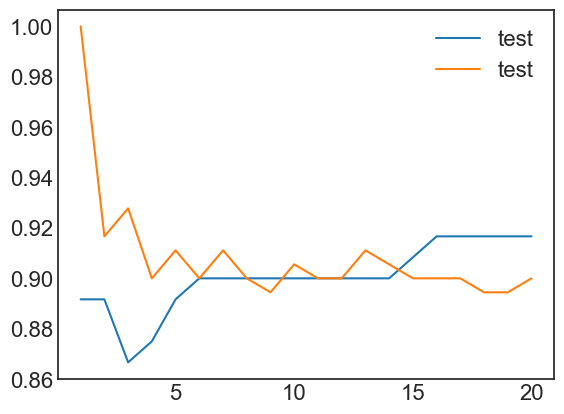

PyObject <matplotlib.legend.Legend object at 0x1a433e7f60>

In [18]:
ks = 1:20
test_accuracy = zeros(length(ks))
train_accuracy = zeros(length(ks))
for (i,k) in enumerate(ks)
    #build KNN classifier
    knn = KNeighborsClassifier(n_neighbors = k)
    #fit on training data
    knn.fit(X_train, y_train)
    #store accuracy
    y_test_pred = knn.predict(X_test)
    test_accuracy[i] = knn.score(X_test,y_test)
    train_accuracy[i] = knn.score(X_train,y_train)
end
test_accuracy
figure()
plot(ks,test_accuracy,label="test")
plot(ks,train_accuracy,label="test")
legend()

the optimal $k$ is around 8. So we should train our $k$-NN algo with $k=8$, then deploy this model, since it should result in the best accuracy on unseen data.

In [24]:
using ScikitLearn.CrossValidation: KFold

In [25]:
K = 5 #number of folds

kf = KFold(n_tumors, n_folds=K, shuffle=true)

5-element Array{Tuple{Array{Int64,1},Array{Int64,1}},1}:
 ([1, 2, 4, 5, 6, 7, 11, 12, 13, 15  …  288, 289, 291, 292, 294, 296, 297, 298, 299, 300], [199, 249, 250, 237, 276, 247, 162, 69, 56, 9  …  116, 72, 161, 196, 82, 293, 3, 285, 143, 68])  
 ([1, 3, 4, 5, 6, 8, 9, 10, 11, 12  …  288, 290, 291, 293, 294, 295, 297, 298, 299, 300], [102, 176, 194, 289, 19, 287, 206, 147, 184, 16  …  59, 205, 93, 44, 2, 296, 216, 73, 244, 211])  
 ([1, 2, 3, 4, 6, 7, 8, 9, 10, 11  …  290, 292, 293, 294, 295, 296, 297, 298, 299, 300], [275, 39, 126, 182, 98, 123, 253, 273, 117, 169  …  80, 110, 251, 228, 79, 195, 148, 157, 230, 41])
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  291, 292, 293, 294, 295, 296, 297, 298, 299, 300], [245, 15, 86, 54, 118, 53, 234, 200, 264, 272  …  274, 269, 78, 47, 172, 100, 259, 33, 24, 104])    
 ([2, 3, 5, 7, 8, 9, 10, 11, 12, 14  …  286, 287, 288, 289, 290, 291, 292, 293, 295, 296], [227, 4, 226, 298, 294, 171, 36, 167, 60, 265  …  144, 222, 260, 248, 97, 210, 32, 89, 1, 109]) 

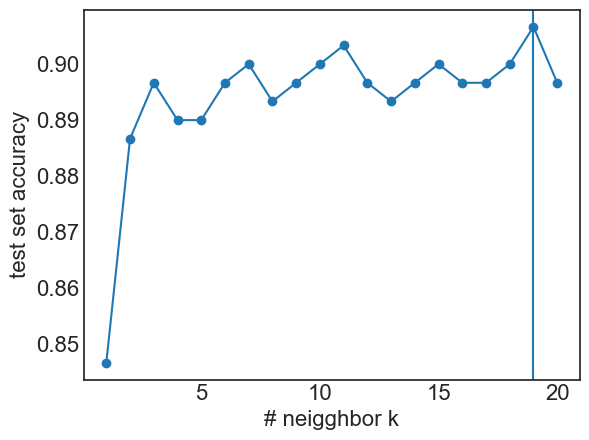

PyObject <matplotlib.lines.Line2D object at 0x1a41d7d7f0>

In [32]:
ks = 1:20
test_accuracy = zeros(length(ks))
for k in ks
#accuracy = 0.0
 test_accuracy[k]=0.0   
for (train_ids, test_ids) in kf
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x[train_ids, :], y[train_ids])
    y_pred = knn.predict(x[test_ids, :])
    #accuracy = sum(y_pred.==y[test_ids])/length(test_ids)
    #accuracy = knn.score(x[test_ids,:],y[test_ids])
    #println("accuracy = ", accuracy)
    test_accuracy[k] +=knn.score(x[test_ids, :], y[test_ids])
end
    test_accuracy[k]/=K
#println("test set accuracy for k = ",k," is ", accuracy/K)
end

k_max_test_accuracy = findfirst(maximum(test_accuracy).==test_accuracy)
k_max_test_accuracy = argmax(test_accuracy)
figure()
xlabel("# neigghbor k")
ylabel("test set accuracy") 
plot(ks, test_accuracy, marker ="o")
axvline(x=k_max_test_accuracy)
#maximum(test_accuracy)
#findfirst(0.9066666666666666.==test_accuracy)
#argmax(test_accuracy)